In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm, expon
import pandas_datareader.data as web
import math

# Objective: A strategy that opens position at market open and close position at market close (does not hold over night).
<br>
Trying to use logistic regression on features such as the moving averages, last day return, and volume from last day to predict whether SP500 will move up or down the next day 

## data preprocess

In [15]:
start_date = '1987-01-16'
end_date = '2021-10-25'
stocks = ['QQQ','SPY','DIA']
data = {}
for s in stocks:
    data[s] = web.DataReader(name=s, data_source='yahoo', start=start_date, end= end_date).reset_index()

In [16]:
def ma_sd(data,n,n_sd):
    df=data.copy()
    ma = data['Adj Close'].rolling(n).mean()
    sd = data['Adj Close'].rolling(n).std()
    data['ma'] = ma
    
    df[str(n)+'ma'] = data.apply(lambda x : x['Adj Close'] / x['ma'],axis = 1)
    
    return df

In [17]:
for s in stocks:
    for i in [20,50,100,200]:
            data[s] = ma_sd(data[s],i,1).fillna(0)

In [18]:
for s in stocks:
    data[s]['d_volume'] = np.log(data[s]['Volume']/data[s]['Volume'].shift(1))
    data[s]['intra_return'] = data[s].apply(lambda x: np.log(x.Close/x.Open),axis = 1)
    data[s]['y'] = data[s].apply(lambda x: 1 if x.Close > x.Open else 0,axis = 1).shift(-1)
    data[s] = data[s][data[s]['Date'] > '2000-01-01'].reset_index().drop('index',axis =1 )
data['SPY'].head()

,Date,High,Low,Open,Close,Volume,Adj Close,20ma,50ma,100ma,200ma,d_volume,intra_return,y
0,2000-01-03,148.25000,143.875000,148.25000,145.4375,8164300.0,97.195297,1.013909,1.038933,1.071646,1.083240,0.945188,-0.019154,0.0
1,2000-01-04,144.06250,139.640625,143.53125,139.7500,8089800.0,93.394379,0.975171,0.996884,1.028957,1.040457,-0.009167,-0.026698,1.0
2,2000-01-05,141.53125,137.250000,139.93750,140.0000,12177900.0,93.561462,0.977351,0.997120,1.030226,1.041743,0.409019,0.000447,0.0
3,2000-01-06,141.50000,137.750000,139.62500,137.7500,6227200.0,92.057823,0.962525,0.979665,1.013319,1.024547,-0.670696,-0.013520,1.0
4,2000-01-07,145.75000,140.062500,140.31250,145.7500,8066500.0,97.404129,1.016759,1.034214,1.071235,1.083351,0.258793,0.038021,0.0


SPY

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [20]:
x = data['SPY'].iloc[:-1,7:13]
y = data['SPY']['y'].iloc[:-1]
print(x.shape)
from sklearn.model_selection import train_test_split
X_train, X_test = x.iloc[:4500],x.iloc[4500:]
y_train ,y_test = y.iloc[:4500],y.iloc[4500:]
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test)

(5488, 6)


In [21]:
x.head()

,20ma,50ma,100ma,200ma,d_volume,intra_return
0,1.013909,1.038933,1.071646,1.083240,0.945188,-0.019154
1,0.975171,0.996884,1.028957,1.040457,-0.009167,-0.026698
2,0.977351,0.997120,1.030226,1.041743,0.409019,0.000447
3,0.962525,0.979665,1.013319,1.024547,-0.670696,-0.013520
4,1.016759,1.034214,1.071235,1.083351,0.258793,0.038021


In [22]:
y.head()

0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: y, dtype: float64

## This whole strategy doesn't hold position over night. It is on intraday trading and to simplify the process,  it opens the position when market opens at 9:30 AM and closes out the position when market closes at 4:00 PM. For this Reason, it could miss out the overnight jump of the price if compared to long term holding.

## EDA Let's try the most simple one: long every day from open to close on training

/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


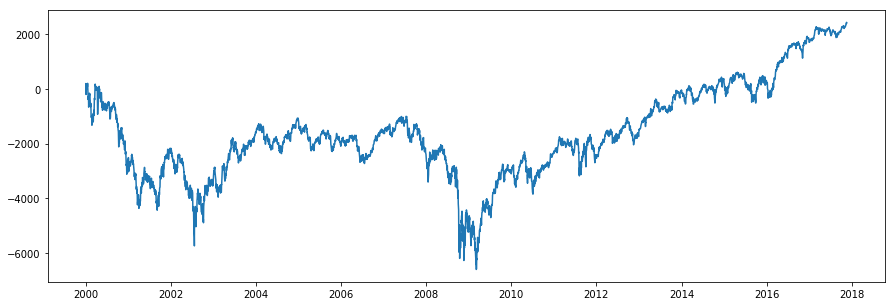

In [23]:
action = np.ones(len(y_train))
data['SPY']['buy_today?'] = pd.Series(action,index= np.arange(start=1, stop=4501, step=1))
results = data['SPY'][['Open','Close','buy_today?']].iloc[:4500]
profit = results.apply(lambda x: (x.Close - x.Open)/x.Open if x['buy_today?'] == True else (x.Open - x.Close)/x.Open, axis =1)
cumsum = []
p0 = 0
for i in profit:
    p0+= i*10000
    cumsum.append(p0)
plt.figure(figsize = (15,5))
plt.plot(data['SPY']['Date'].iloc[0:4500],cumsum)


# Logistic Linear Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

logreg = LogisticRegression().fit(X_train, y_train)
print('Accuracy train',logreg.score(X_train,y_train))
print('Accuracy test',logreg.score(X_test,y_test))

Accuracy train 0.5268888888888889
Accuracy test 0.5323886639676113


/Users/zesenying/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zesenying/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/Users/zesenying/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`

# Training

### Result with default threshold

In [28]:
pred_train = logreg.predict(X_train)
cm = confusion_matrix(y_train,pred_train)
print(cm)
precision_recall_fscore_support(y_train, pred_train, average='macro')

[[ 143 1985]
 [ 144 2228]]


/Users/zesenying/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:283: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)


(0.5135485733142232, 0.5032454925255804, 0.3975579733725718, None)

/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


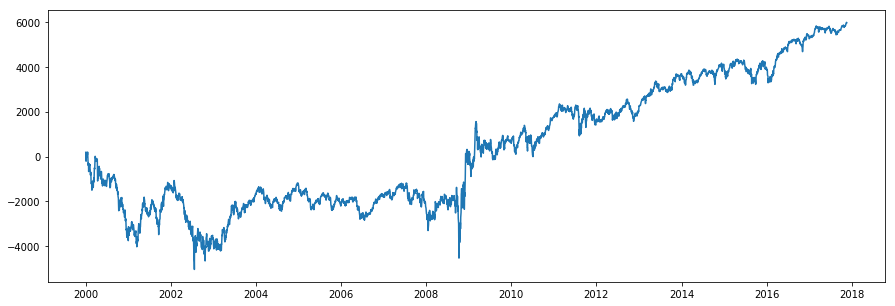

In [29]:
data['SPY']['buy_today?'] = pd.Series(pred_train,index= np.arange(start=1, stop=4501, step=1))
results = data['SPY'][['Open','Close','buy_today?']].iloc[:4500]
profit = results.apply(lambda x: (x.Close - x.Open)/x.Open if x['buy_today?'] == True else (x.Open - x.Close)/x.Open, axis =1)
cumsum = []
p0 = 0
for i in profit:
    p0+= i*10000
    cumsum.append(p0)
plt.figure(figsize = (15,5))
plt.plot(data['SPY']['Date'].iloc[0:4500],cumsum)



### modify prediction probability threshold

In [30]:
print("find average of the probability of being classified to 0 is")
print(np.mean([i[0] for i in logreg.predict_proba(X_train)]))
print(logreg.predict_proba(X_train))

find average of the probability of being classified to 0 is
0.47291366250561523
[[0.43499134 0.56500866]
 [0.44689526 0.55310474]
 [0.4691787  0.5308213 ]
 ...
 [0.46288294 0.53711706]
 [0.47975028 0.52024972]
 [0.46631658 0.53368342]]


In [31]:
### try to iterate through possible thresholds that could make the model better

In [32]:
for z in np.arange(0.45,0.50,0.001):
    pred_train = [i[0]<z for i in logreg.predict_proba(X_train)]
    print(precision_recall_fscore_support(y_train, pred_train, average='macro'),z)

(0.5127148704893731, 0.5043993045429763, 0.3964027434950956, None) 0.45
(0.5104552193845248, 0.5039159080246991, 0.40103621506323195, None) 0.451
(0.5038007051334432, 0.5015112084595975, 0.4024238384325817, None) 0.452
(0.4986685069416254, 0.49943141475104286, 0.405295649920134, None) 0.453
(0.4997951483588726, 0.49990530182961623, 0.4120307553143374, None) 0.454
(0.49790255994831073, 0.4989761503252228, 0.4154709676703698, None) 0.455
(0.4956701371800886, 0.4977636967629867, 0.418978387537699, None) 0.456
(0.4990991365769198, 0.49950233932216714, 0.42697377337033704, None) 0.457
(0.5082540365237276, 0.5048969652208092, 0.4396306670906112, None) 0.458
(0.5062266009852217, 0.5039127382114645, 0.44424491425076174, None) 0.459
(0.5119750853928069, 0.507970099151758, 0.45452407099202774, None) 0.46
(0.5143463765572908, 0.5101235910180173, 0.46307518192633146, None) 0.461
(0.5124061374272137, 0.5092709112579087, 0.4685722526356007, None) 0.462
(0.5087958833414302, 0.5070017212085863, 0.4736

### possible good choice
<br>
(0.5248434551381026, 0.5247875432679506, 0.52477383498442, None) 0.47400000000000003
<br>
(0.5290829935002067, 0.5252566756266721, 0.5136161641044803, None) 0.48000000000000004

### try threshold = 0.474 on training

In [33]:
pred_train = [i[0] < 0.474 for i in logreg.predict_proba(X_train)]
cm = confusion_matrix(y_train,pred_train)
print(cm)
precision_recall_fscore_support(y_train, pred_train, average='macro')

[[1043 1085]
 [1045 1327]]


(0.5248434551381026, 0.5247875432679506, 0.52477383498442, None)

[[1043 1085]
 [1045 1327]]


/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


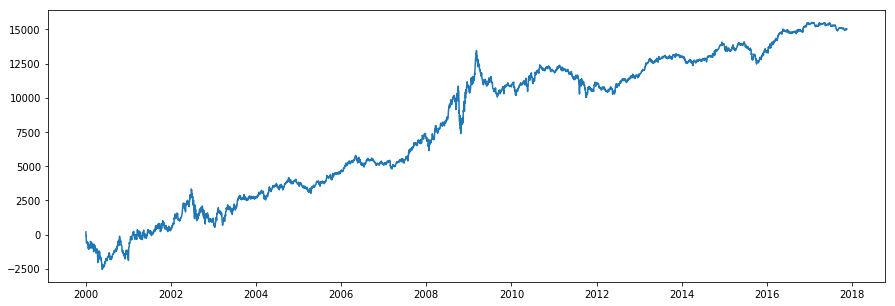

In [34]:
pred_train = [i[0] < 0.474 for i in logreg.predict_proba(X_train)]
cm = confusion_matrix(y_train,pred_train)
print(cm)
precision_recall_fscore_support(y_train, pred_train, average='macro')
data['SPY']['buy_today?'] = pd.Series(pred_train,index= np.arange(start=1, stop=4501, step=1))
results = data['SPY'][['Open','Close','buy_today?']].iloc[:4500]
profit = results.apply(lambda x: (x.Close - x.Open)/x.Open if x['buy_today?'] == True else (x.Open - x.Close)/x.Open, axis =1)
cumsum = []
p0 = 0
for i in profit:
    p0+= i*10000
    cumsum.append(p0)
plt.figure(figsize = (15,5))
plt.plot(data['SPY']['Date'].iloc[0:4500],cumsum)



### try threshold = 0.480 on training

[[ 731 1397]
 [ 695 1677]]


/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


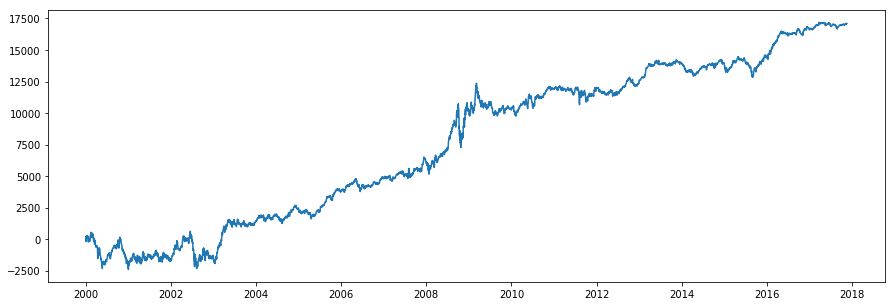

In [38]:
pred_train = [i[0] < 0.480 for i in logreg.predict_proba(X_train)]
cm = confusion_matrix(y_train,pred_train)
print(cm)
precision_recall_fscore_support(y_train, pred_train, average='macro')
data['SPY']['buy_today?'] = pd.Series(pred_train,index= np.arange(start=1, stop=4501, step=1))
results = data['SPY'][['Open','Close','buy_today?']].iloc[:4500]
profit = results.apply(lambda x: (x.Close - x.Open)/x.Open if x['buy_today?'] == True else (x.Open - x.Close)/x.Open, axis =1)
cumsum = []
p0 = 0
for i in profit:
    p0+= i*10000
    cumsum.append(p0)
plt.figure(figsize = (15,5))
plt.plot(data['SPY']['Date'].iloc[0:4500],cumsum)

# Testing

### testing threshold = 0.480
<br>

### chosen  parameter and model

In [40]:
pred_test = [i[0] < 0.480 for i in logreg.predict_proba(X_test)]

[[105 350]
 [117 416]]
Precision, recall, F1score (0.5080269564603769, 0.5056285178236398, 0.4753423551578706, None)


/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Text(0.5, 1.0, 'Testing result')

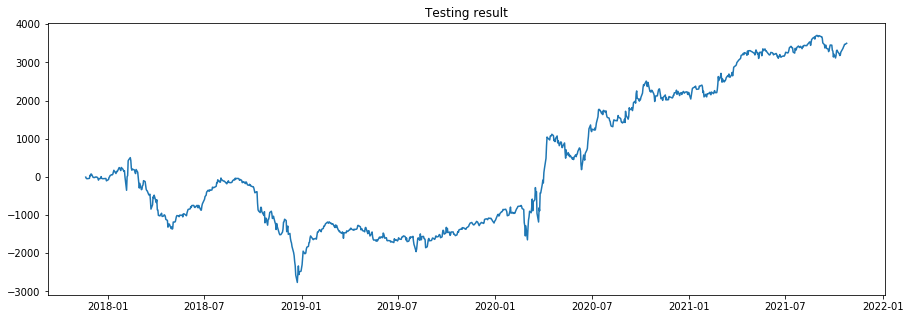

In [56]:
pred_test = [i[0] < 0.480 for i in logreg.predict_proba(X_test)]
cm = confusion_matrix(y_test,pred_test)
print(cm)
print('Precision, recall, F1score',precision_recall_fscore_support(y_test, pred_test, average='macro'))
data['SPY']['buy_today?'] = pd.Series(pred_test,index= np.arange(start=4501, stop=5489, step=1))
results = data['SPY'][['Open','Close','buy_today?']].iloc[4500:]
results
profit = results.apply(lambda x: (x.Close - x.Open)/x.Open if x['buy_today?'] == True else (x.Open - x.Close)/x.Open, axis =1)


cumsum = []
p0 = 0
for i in profit:
    p0+= i*10000
    cumsum.append(p0)
plt.figure(figsize = (15,5))
plt.plot(data['SPY']['Date'].iloc[4500:5489],cumsum)
plt.title("Testing result")

### long every day on testing result

/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/zesenying/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


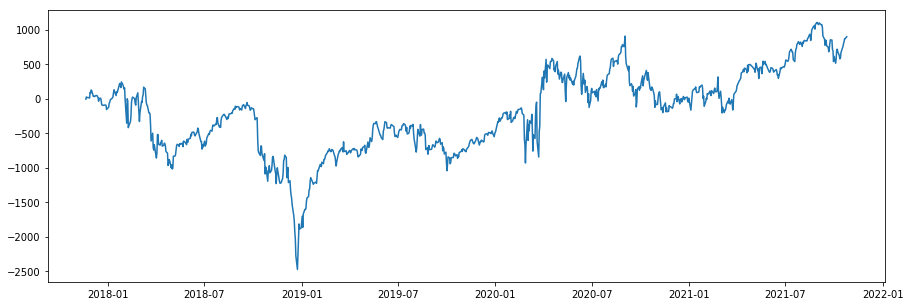

In [57]:
all_long = np.ones(len(pred_test))
data['SPY']['buy_today?'] = pd.Series(all_long,index= np.arange(start=4501, stop=5489, step=1))
results = data['SPY'][['Open','Close','buy_today?']].iloc[4500:]
profit = results.apply(lambda x: (x.Close - x.Open)/x.Open if x['buy_today?'] == True else (x.Open - x.Close)/x.Open, axis =1)
cumsum = []
p0 = 0
for i in profit:
    p0+= i*10000
    cumsum.append(p0)
plt.figure(figsize = (15,5))
plt.plot(data['SPY']['Date'].iloc[4500:5489],cumsum)


## Compare the model results with long every day action, the results with model look better, there is more upside than downside